<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/nyu-deep-learning-2020/05_convolution_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolution neural network

In this notebook, we train a multilayer perceptron (FC network) and a convolution neural network (CNN) for the classification task on the MNIST dataset. 

Note that both networks have an equal number of parameters. 

**To perform well, we need to incorporate some prior knowledge about the problem**

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

**Reference**:

[ConvNet using PyTorch (CNN)](https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-3/)

In [ ]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning
!cp -r pytorch-Deep-Learning/res .
!rm -rf pytorch-Deep-Learning

In [2]:
# Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import numpy as np
import random
import math

from IPython import display
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib.pyplot import plot, title, axis
from matplotlib import pyplot as plt

In [3]:
# Set style (needs to be in a new cell)
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# function to count number of parameters
def get_n_params(model):
  np = 0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

##Loading the Dataset

Before training, we normalize our data so that the initialization of the network will match our data distribution (very important!). 

Also, make sure that the following five operations/steps are present in your training:

1. Feeding data to the model
2. Computing the loss
3. Cleaning the cache of accumulated gradients with `zero_grad()`
4. Computing the gradients
5. Performing a step in the optimizer method

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size = 28 * 28    # images are 28x28 pixels
output_size = 10        # there are 10 classes

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST("../data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])),
  batch_size=64, 
  shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST("../data", train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])),
  batch_size=1000, 
  shuffle=True
)

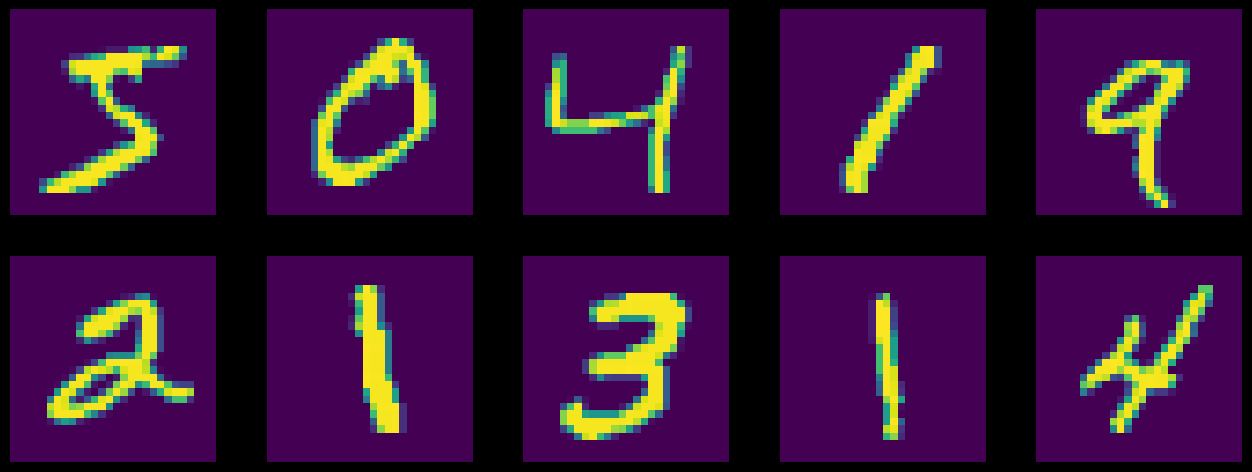

In [7]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  image, _ = train_loader.dataset.__getitem__(i)
  plt.imshow(image.squeeze().numpy())
  plt.axis("off");

First, we train both the networks on the normalized MNIST data.

## Creating the model classes

Let's define small fully-connected and ConvNet network.

In [8]:
class FCLayer(nn.Module):
  def __init__(self, input_size, n_hidden, output_size):
    super(FCLayer, self).__init__()

    self.input_size = input_size
    self.network = nn.Sequential(
      nn.Linear(input_size, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, output_size),
      nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = x.view(-1, self.input_size)
    return self.network(x)

In [9]:
class CNN(nn.Module):
  def __init__(self, input_size, n_feature, output_size):
    super(CNN, self).__init__()

    self.n_feature = n_feature 
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5)
    self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x, verbose=False):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = x.view(-1, self.n_feature * 4 * 4)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x

Let's define method for training and testing the model.

In [10]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # send to device
    data, target = data.to(device), target.to(device)
    
    # permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def test(model, perm=torch.arange(0, 784).long()):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    # send to device
    data, target = data.to(device), target.to(device)

    # permute pixels
    data = data.view(-1, 28 * 28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    output = model(data)

    test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1]   # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  accuracy_list.append(accuracy)
  print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")

##Training the model

First, we train both the networks on the normalized MNIST data. 

The accuracy of the FC network turned out to be 87% while the accuracy of the CNN turned out to be 95%. 

Given the same number of parameters, the CNN managed to train many more filters.

In [11]:
# let's train a small fully-connected network
n_hidden = 8

model_fnn = FCLayer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_fnn)}")

for epoch in range(0, 1):
  train(epoch, model_fnn)
  test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.370413
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.005335
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.641455
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.185627
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.986641
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.901969
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.052183
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.636180
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.525725
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.366614

Test set: Average loss: 0.5243, Accuracy: 8438/10000 (84%)



In [12]:
# let's train a ConvNet with the same number of parameters
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_cnn)}")

for epoch in range(0, 1):
  train(epoch, model_cnn)
  test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297352
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.059946
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.815850
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.305471
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.334496
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.358385
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.221877
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.152831
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.105973
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.195082

Test set: Average loss: 0.1738, Accuracy: 9481/10000 (95%)



In the FC network, filters that try to get some dependencies between things that are further away with things that are close by, are trained. They are completely wasted. 

Instead, in the convolutional network, all these parameters concentrate on the relationship between neighbour pixels.

**The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images.**

* **Use of convolution**: Locality and stationarity in images
* **Pooling**: builds in some translation invariance

**What happens if the assumptions are no longer true?**

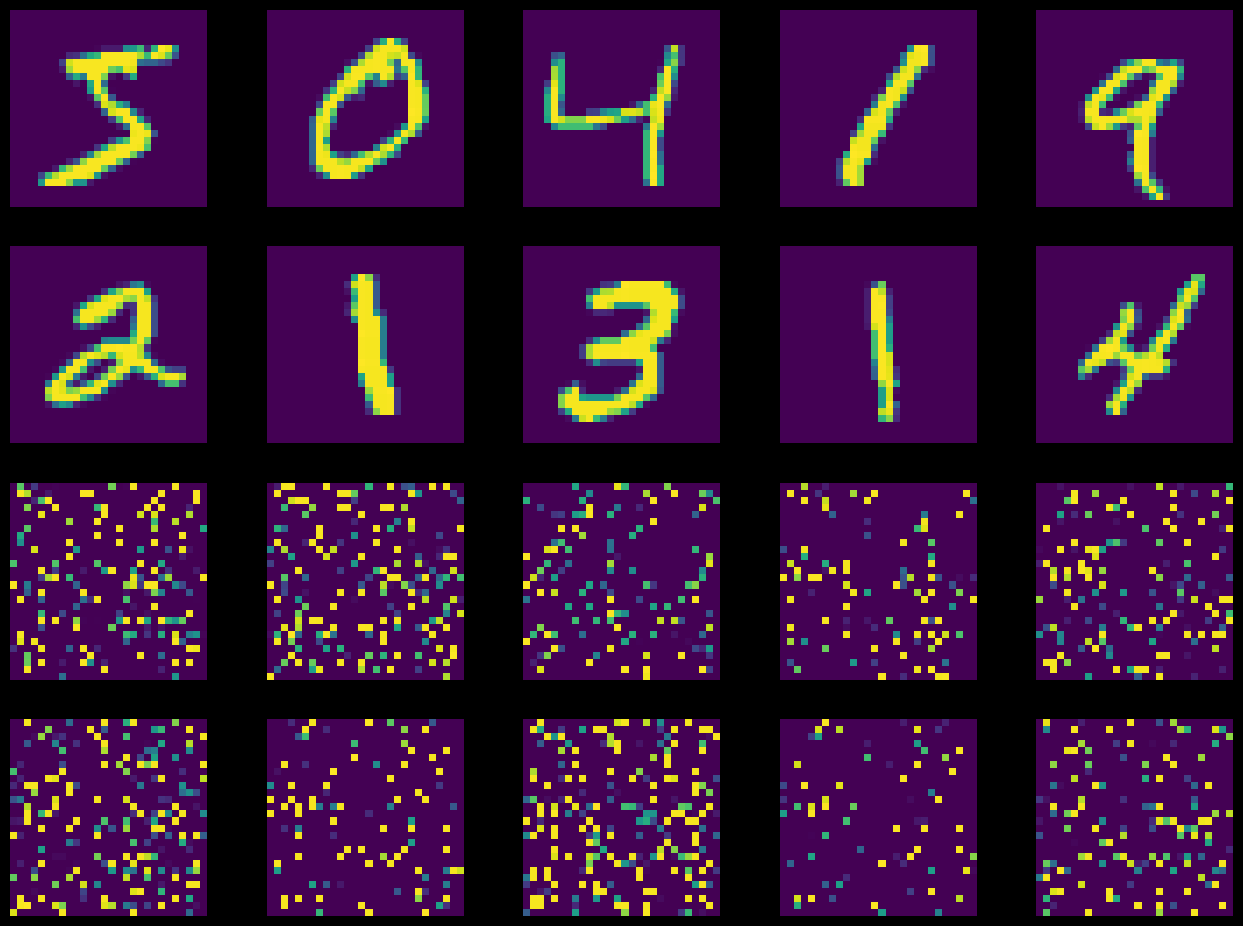

In [13]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
  image, _ = train_loader.dataset.__getitem__(i)
  # permute pixels
  image_perm = image.view(-1, 28*28).clone()
  image_perm = image_perm[:, perm]
  image_perm = image_perm.view(-1, 1, 28, 28)
  plt.subplot(4, 5, i + 1)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off')
  plt.subplot(4, 5, i + 11)
  plt.imshow(image_perm.squeeze().numpy())
  plt.axis('off')

##Training model with permuted pixels

Let's train ConvNet with permuted pixels.

In [14]:
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_cnn)}")

for epoch in range(0, 1):
  train(epoch, model_cnn, perm)
  test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.289146
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.257534
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.994800
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.609178
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.027645
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.041189
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.967643
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.777714
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.563221
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.431925

Test set: Average loss: 0.5541, Accuracy: 8195/10000 (82%)



Let's train fully-connected with permuted pixels.

In [15]:
n_hidden = 8

model_fnn = FCLayer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_fnn)}")

for epoch in range(0, 1):
  train(epoch, model_fnn, perm)
  test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348221
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.949437
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.480625
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.044597
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.763889
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.642845
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.656819
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.440933
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.356660
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.267364

Test set: Average loss: 0.4283, Accuracy: 8764/10000 (88%)



The performance of the FC network almost stayed unchanged (85%), but the accuracy of CNN dropped to 83%. 

This is because, after a random permutation, the images no longer hold the three properties of locality, stationarity, and compositionality, that are exploitable by a CNN.

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

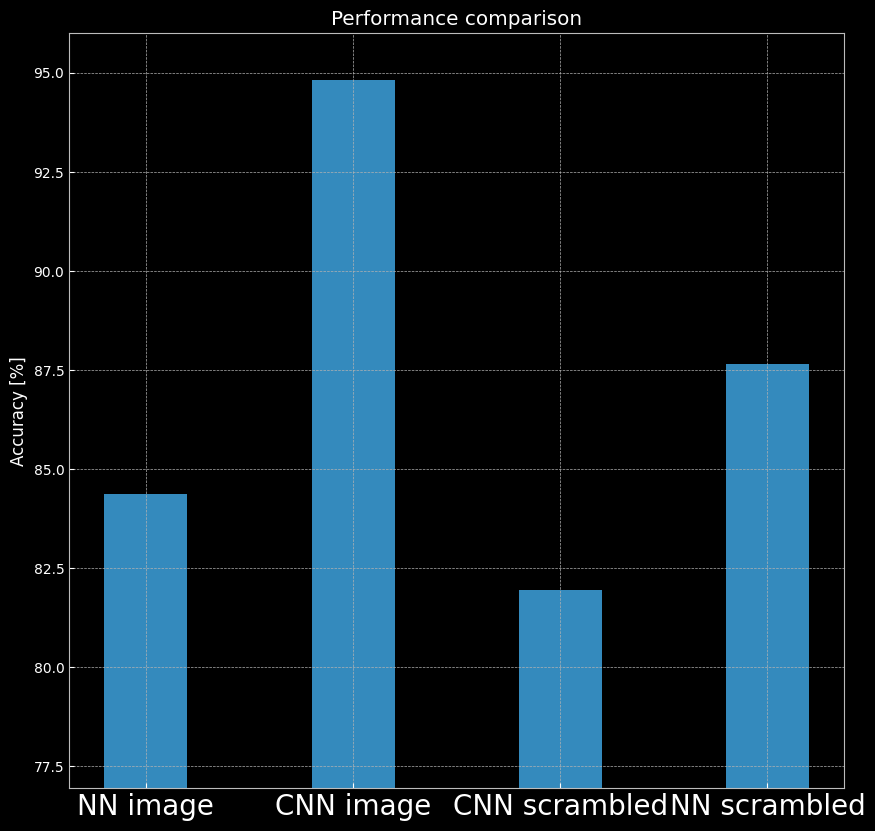

In [16]:
plt.bar(('NN image', 'CNN image', 'CNN scrambled', 'NN scrambled'), accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

Let's check the model parameters.

In [17]:
print(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [21]:
print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', '

In [19]:
print(model_fnn)

FCLayer(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [20]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', '